## Mushroom Classification with Random Forests
### Safe to eat or deadly poison?


- Data source： https://www.kaggle.com/uciml/mushroom-classification/data  
- Compare Random Forests, Decision Tree, and Logistic Regression models

In [1]:

%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

np.random.seed(19)

In [2]:
data_folder = ""
data = pd.read_csv(os.path.join(data_folder, "mushrooms.csv"), header=None)


In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
1,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
2,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
3,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
4,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u


In [4]:
data[0] = data.apply(lambda row: 0 if row[0] == 'e' else 1, axis=1)

In [5]:
# Replace "null" with missing"
cols = np.arange(1,23)
for col in cols:
    if np.any(data[col].isnull()):
        data.loc[df[col].isnull(), col] = 'missing'


In [6]:
labelEncoders = dict()

# one hot encoding
for col in cols:
    encoder = LabelEncoder()
    values = data[col].tolist()
    values.append('missing')  
    encoder.fit(values)
    labelEncoders[col] = encoder

dimensionality = 0
for col, encoder in labelEncoders.items():
    dimensionality += len(encoder.classes_)
print("dimensionality:  %d" % (dimensionality))

dimensionality:  161


In [7]:
def transform(df):
    N, _ = df.shape
    X = np.zeros((N, dimensionality))
    i = 0
    for col ,encoder in labelEncoders.items():
        k = len(encoder.classes_)
        X[np.arange(N), encoder.transform(df[col]) + i] = 1
        i += k
    return X

In [8]:
X = transform(data)
Y = data[0].as_matrix()

### Logistic Regression

In [9]:
logistic_model = LogisticRegression()
print("logistic Regression performance: %f" % (cross_val_score(logistic_model, X, Y, cv=8).mean()))

logistic Regression performance: 0.927358


### Decision Tress

In [10]:
tree_model = DecisionTreeClassifier()
print("Decision Tree performance: %f" % (cross_val_score(tree_model, X, Y, cv=8).mean()))

Decision Tree performance: 0.945475


### Random Forests

In [11]:
forest = RandomForestClassifier(n_estimators=20)
print("Random Forest performance: %f" % (cross_val_score(tree_model, X, Y, cv=8).mean()))

Random Forest performance: 0.942519


In [12]:
from sklearn.base import BaseEstimator

In [13]:
class FakeRandomForest(BaseEstimator):
    
    def __init__(self, M):
        self.M = M
        
        
    def fit(self, X, Y, n_features=None):
        N,D = X.shape
        if n_features is None:
            n_features = int(np.sqrt(D))
        
        self.models = []
        
        self.features = []
        
        for m in range(self.M):
            tree = DecisionTreeClassifier()
            
            idx = np.random.choice(N, size=N, replace=True)
            X_current = X[idx]
            Y_current = Y[idx]
            
            features = np.random.choice(D, size=n_features, replace=False)
            
            tree.fit(X_current[:, features], Y_current)
            self.features.append(features)
            self.models.append(tree)
            
    
    def predict(self, X):
        N = len(X)
        results = np.zeros(N)
        for features, tree in zip(self.features, self.models):
            results += tree.predict(X[:, features])
        return np.round(results/ self.M)
    
    def score(self, X, Y):
        prediction = self.predict(X)
        return np.mean(prediction == Y)
        
            
            
            

### Bagging Decision Tress

In [14]:
class BaggedTreeClassifier(BaseEstimator):
    def __init__(self, M):
        self.M = M

    def fit(self, X, Y):
        N = len(X)
        self.models = []
        for m in range(self.M):
            idx = np.random.choice(N, size=N, replace=True)
            Xb = X[idx]
            Yb = Y[idx]

            model = DecisionTreeClassifier(max_depth=2)
            model.fit(Xb, Yb)
            self.models.append(model)

    def predict(self, X):
        # no need to keep a dictionary since we are doing binary classification
        predictions = np.zeros(len(X))
        for model in self.models:
            predictions += model.predict(X)
        return np.round(predictions / self.M)

    def score(self, X, Y):
        P = self.predict(X)
        return np.mean(Y == P)

In [15]:
baggedtc = BaggedTreeClassifier(20)

In [16]:
cross_val_score(baggedtc, X, Y, cv=8).mean()

0.9064519413521586

In [17]:
fakerf = FakeRandomForest(20)

In [18]:
cross_val_score(fakerf, X, Y, cv=8).mean()

0.8918014962569334

### Pridict house price with Random Forests Regression  

- Data source： https://www.kaggle.com/harlfoxem/housesalesprediction/data  
- Compare Random Forest Regression with Linear Regression

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

In [20]:
house_data = pd.read_csv(os.path.join(data_folder, "kc_house_data.csv"))

In [21]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [22]:
house_data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [23]:
# price is the target
NUMERICAL_COLS = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above','sqft_basement',
                 'sqft_living15', 'sqft_lot15']

In [24]:
scalers = dict()
for col in NUMERICAL_COLS:
    scaler = StandardScaler()
    scaler.fit(house_data[col].as_matrix().astype(np.float64).reshape(-1,1))
    scalers[col] = scaler
    

In [25]:
def transform_numerical(df):
    N, _ = df.shape
    D = len(NUMERICAL_COLS)
    result = np.zeros((N,D))
    i = 0
    for col, scaler in scalers.items():
        result[:, i] = scaler.transform(df[col].as_matrix().astype(np.float64).reshape(1,-1))
        i += 1
    return result    


In [26]:
from sklearn.model_selection import train_test_split

In [27]:
hdata = transform_numerical(house_data)

In [28]:
train_data, test_data = train_test_split(hdata, test_size=0.2)

In [29]:
trainX, trainY = train_data[:,1:], train_data[:, 0]
testX, testY = test_data[:, 1:], test_data[:, 0]


In [30]:
rfregressor = RandomForestRegressor(n_estimators=100)
rfregressor.fit(trainX, trainY)
predictions = rfregressor.predict(testX)

### Show result

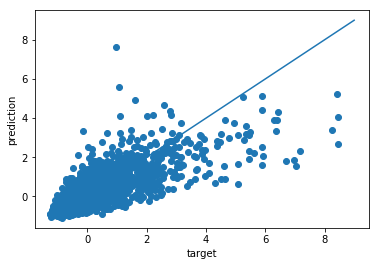

In [31]:
plt.scatter(testY, predictions)
plt.xlabel("target")
plt.ylabel("prediction")
ymin = np.round(min(min(testY), min(predictions)))
ymax = np.ceil(max(max(testY), max(predictions)))
r = range(int(ymin), int(ymax) + 1)
plt.plot(r,r)
plt.show()

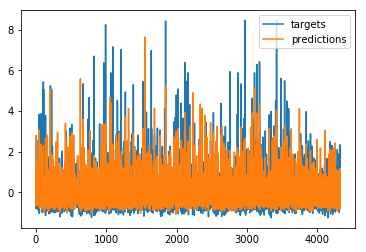

In [32]:
plt.plot(testY, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

In [33]:
lr = LinearRegression()
print("linear regression performance: %f" % (cross_val_score(lr, trainX, trainY).mean()))

linear regression performance: 0.519845


In [34]:
print("random forest regressor performance: %f" % (cross_val_score(rfregressor, trainX, trainY).mean()))

random forest regressor performance: 0.621258


In [35]:
lr.fit(trainX, trainY)
print("linear regression test score: %f" % (lr.score(testX, testY)))

linear regression test score: 0.497784


In [36]:
rfregressor.fit(trainX, trainY)
print("random forest regressor test score: %f" % (rfregressor.score(testX, testY)))

random forest regressor test score: 0.605620
